# Sweet Lift Taxi Demand Prediction

Sweet Lift is a taxi company that specializes in providing reliable transportation services to and from airports. However, the company faces a recurring challenge of driver shortages during peak hours, leading to unmet customer demand and operational inefficiencies. To address this issue, Sweet Lift is investing in a machine learning solution to predict the number of taxi orders expected in the next hour, enabling better resource planning and driver allocation.

My role in this project is to develop and validate a predictive model capable of accurately forecasting taxi demand. This involves resampling the historical data at one-hour intervals to create a structured dataset, conducting exploratory data analysis to identify trends, and training multiple machine learning models with optimized hyperparameters. The dataset will be divided into training and test sets, with the test set comprising 10% of the original data, to ensure robust evaluation. The model's performance will be assessed using the Root Mean Squared Error (RMSE) metric, with a target threshold of 48 or lower.

By implementing this solution, the goal is to equip Sweet Lift with a reliable forecasting tool to optimize driver availability during peak times, ultimately improving service quality and customer satisfaction.

## Import Library and Data

### Import Library

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

### Import Data

In [ ]:
try:
    # Try loading the file from your laptop path
    data = pd.read_csv("C:/Users/Eugene/Documents/GitHub/TripleTen-Projects/13. Sweet Lift Taxi Demand Prediction/taxi.csv")
except FileNotFoundError:
    # If the file is not found, try loading from the PC path
    data = pd.read_csv("C:/Users/user/OneDrive/Documents/GitHub/TripleTen-Projects/13. Sweet Lift Taxi Demand Prediction/taxi.csv")

### General Data Information

In [3]:
data.sample(10)

,datetime,num_orders
18813,2018-07-09 15:30:00,19
15813,2018-06-18 19:30:00,22
13098,2018-05-30 23:00:00,26
14742,2018-06-11 09:00:00,13
22547,2018-08-04 13:50:00,7
646,2018-03-05 11:40:00,11
17411,2018-06-29 21:50:00,16
22835,2018-08-06 13:50:00,16
10721,2018-05-14 10:50:00,26
15466,2018-06-16 09:40:00,17


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


## Data Preprocessing

### Change Column Type

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [7]:
data.set_index('datetime', inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Resample Data (1H)

In [9]:
data.sort_index(inplace = True)

data_hour = data.resample('1H').sum()

In [10]:
data_hour.sample(10)

,num_orders
datetime,
2018-08-17 19:00:00,84
2018-05-12 22:00:00,58
2018-08-01 08:00:00,66
2018-06-03 16:00:00,90
2018-04-12 16:00:00,119
2018-04-02 22:00:00,66
2018-06-24 10:00:00,60
2018-03-13 07:00:00,20
2018-03-14 03:00:00,57


## Data Analisis

<AxesSubplot:xlabel='datetime'>

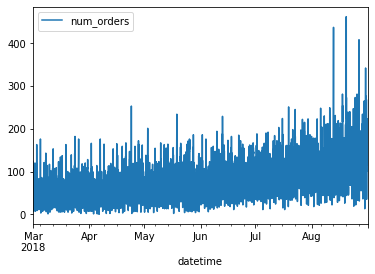

In [11]:
data_hour.plot()

In [12]:
data_hour.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Unclear, hence it required to be examined through trends, seasons and residuals analysis.

<div class="alert alert-success">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

Hebat, Kerja bagus!

</div>

### Decomposed Hourly Analysis

In [13]:
decomposed = seasonal_decompose(data_hour.num_orders, model='additive', period=24)

#### Trend Analysis

Text(0, 0.5, 'Amount Order')

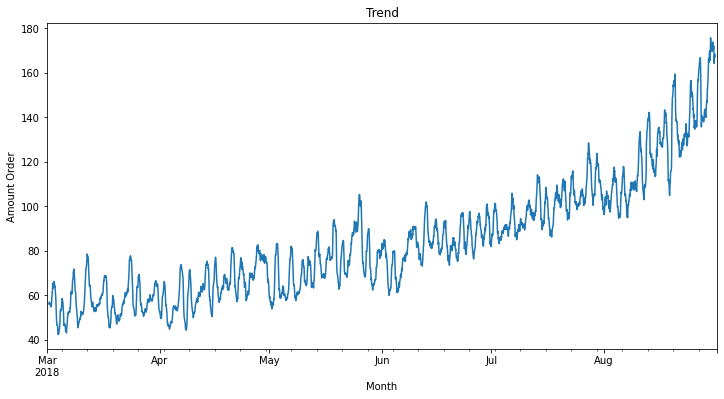

In [14]:
plt.figure(figsize=(12,6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Amount Order')

In [15]:
trend_stats = decomposed.trend.describe()
print("Trend Statistics:\n", trend_stats)

Trend Statistics:
 count    4392.000000
mean       84.269742
std        26.311419
min        42.458333
25%        63.687500
50%        79.666667
75%        99.958333
max       175.729167
Name: trend, dtype: float64


#### Seasonal Analysis

Text(0, 0.5, 'Amount Order')

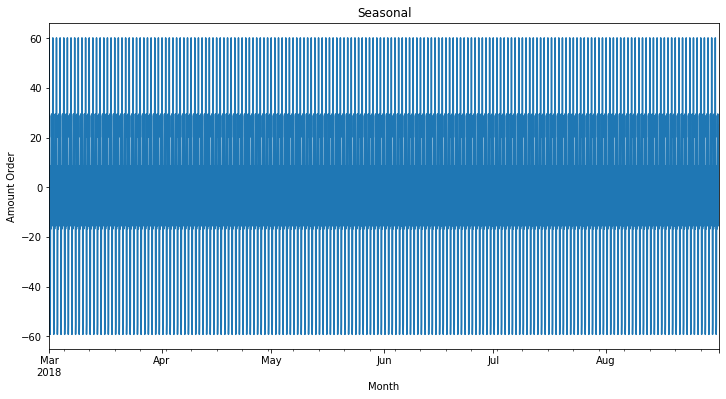

In [16]:
plt.figure(figsize=(12,6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Amount Order')

In [17]:
seasonal_stats = decomposed.seasonal.describe()
print("Seasonal Statistics:\n", seasonal_stats)

Seasonal Statistics:
 count    4.416000e+03
mean     3.089316e-16
std      2.615659e+01
min     -5.918267e+01
25%     -1.174773e+01
50%      3.261489e+00
75%      1.466896e+01
max      6.024811e+01
Name: seasonal, dtype: float64


#### Residual Analysis

Text(0, 0.5, 'Amount Order')

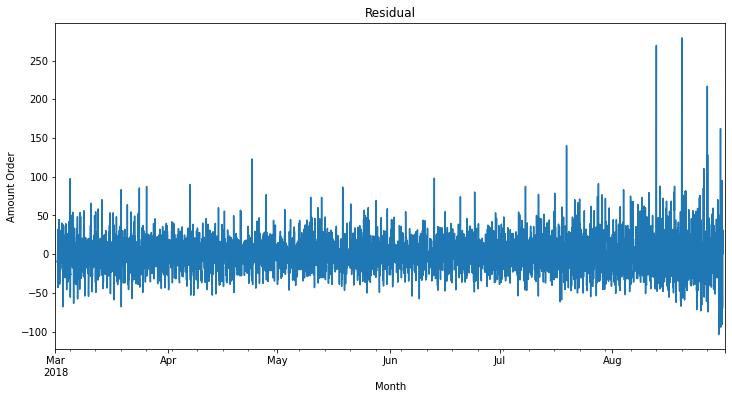

In [18]:
plt.figure(figsize=(12,6))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.xlabel('Month')
plt.ylabel('Amount Order')

In [19]:
residual_stats = decomposed.resid.describe()
print("Residual Statistics:\n", residual_stats)

Residual Statistics:
 count    4392.000000
mean       -0.008130
std        24.696896
min      -103.546496
25%       -14.730950
50%        -1.387969
75%        12.967052
max       279.371423
Name: resid, dtype: float64


#### Summary of Decomposed Analysis 

- Trend Graph Component:
    - Average: ~84 orders/hour
    - Variability: Moderate (Std: ~26)
    - Range: ~42 to ~175 orders/hour
- Seasonal Graph Component:
    - Average: Close to zero
    - Variability: Significant (Std: ~26)
    - Range: ~-59 to ~60 orders/hour
- Residual Graph Component:
    - Average: Close to zero
    - Variability: Substantial (Std: ~25)
    - Range: ~-104 to ~279 orders/hour

From the Seasonal Graph and statistics, the data still consider to be unclear for exhibiting a seasonal pattern, hence it required further process. To handle it, a resampling technique will re-apply towards the data_hour into the daily basis.

### Resample Data (1D)

In [20]:
data_day = data_hour.resample('1D').sum()

In [21]:
data_day.sample(10)

,num_orders
datetime,
2018-04-23,1685
2018-04-17,1409
2018-04-13,1684
2018-04-22,1567
2018-07-17,2096
2018-05-31,1893
2018-05-12,1651
2018-07-21,2460
2018-03-26,1561


create a moving average and rolling standard deviation pattern within 10 windows

In [22]:
data_day['rolling_mean'] = data_day['num_orders'].rolling(10).mean()
data_day['rolling_std'] = data_day['num_orders'].rolling(10).std()

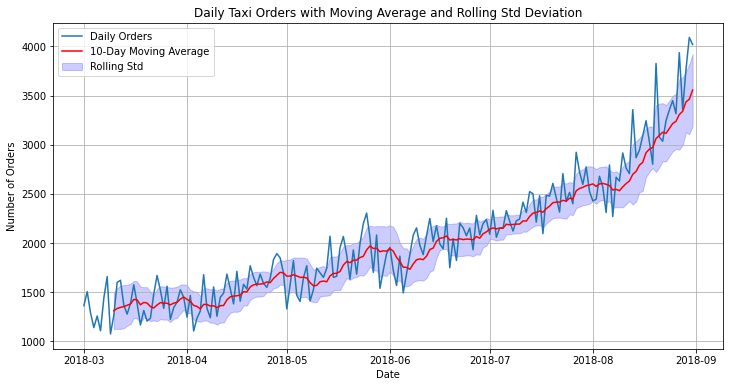

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data_day.index, data_day['num_orders'], label='Daily Orders')
plt.plot(data_day.index, data_day['rolling_mean'], label='10-Day Moving Average', color='red')
plt.fill_between(data_day.index, data_day['rolling_mean'] - data_day['rolling_std'], 
                 data_day['rolling_mean'] + data_day['rolling_std'], color='blue', alpha=0.2, label='Rolling Std')
plt.title('Daily Taxi Orders with Moving Average and Rolling Std Deviation')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
data_day.describe()

,num_orders,rolling_mean,rolling_std
count,184.000000,175.000000,175.000000
mean,2026.146739,1999.926857,181.008130
std,635.874120,547.629114,55.052996
min,1076.000000,1311.200000,93.079655
25%,1547.500000,1572.700000,149.254626
50%,1911.500000,1917.600000,170.762864
75%,2349.750000,2362.400000,200.839930
max,4090.000000,3555.700000,365.935954


#### Seasonality Summary

Overall Trend:
- Show an upward trend, with a smooth movement
- No extreme values in the standard deviation, along with smooth mean values
- Daily taxi orders average around 2026, ranging from 1076 to 4090.
- The 10-day moving average closely follows this trend, averaging around 1999.9 orders.
- Variability, as measured by the rolling standard deviation, averages approximately 181 orders.

Variability:
- Daily orders exhibit significant variability, with a standard deviation of about 636.
- The variability decreases when considering the smoother trend of the 10-day moving average and rolling standard deviation.

### Decomposed Weekly Analysis

In [25]:
data_day

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01,1364,NaN,NaN
2018-03-02,1506,NaN,NaN
2018-03-03,1290,NaN,NaN
2018-03-04,1141,NaN,NaN
2018-03-05,1259,NaN,NaN
...,...,...,...
2018-08-27,3936,3306.7,357.294790
2018-08-28,3357,3339.1,344.166772
2018-08-29,3762,3435.2,309.658880


Towards the weekly group, the data will start from the begining of the month. To delve into the weekly data as example, the data will be assigned from Sunday 13/05/2018 to Saturday 19/05/2018.

In [26]:
decomposed_week = seasonal_decompose(data_hour['2018-05-13':'2018-05-19'])

#### Trend within Interval

Text(0, 0.5, 'Amount Order')

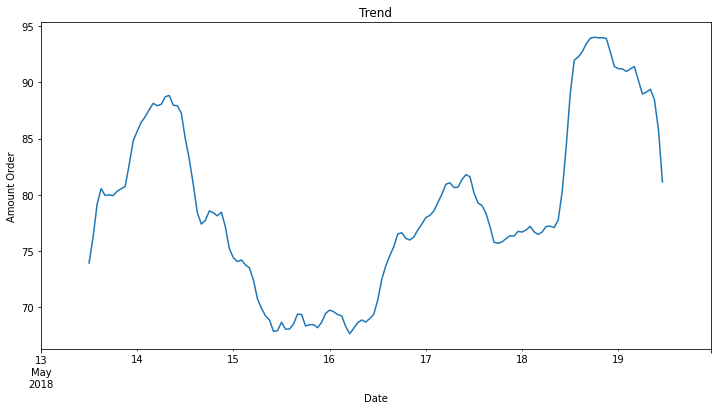

In [27]:
plt.figure(figsize=(12,6))
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Amount Order')

In [28]:
week_trend_stats = decomposed_week.trend.describe()
print("Trend Statistics from 13/05/2018 to 19/05/2018:\n", week_trend_stats)

Trend Statistics from 13/05/2018 to 19/05/2018:
 count    144.000000
mean      78.984230
std        7.649244
min       67.645833
25%       73.895833
50%       77.864583
75%       84.838542
max       94.000000
Name: trend, dtype: float64


#### Seasonal within Interval

Text(0, 0.5, 'Amount Order')

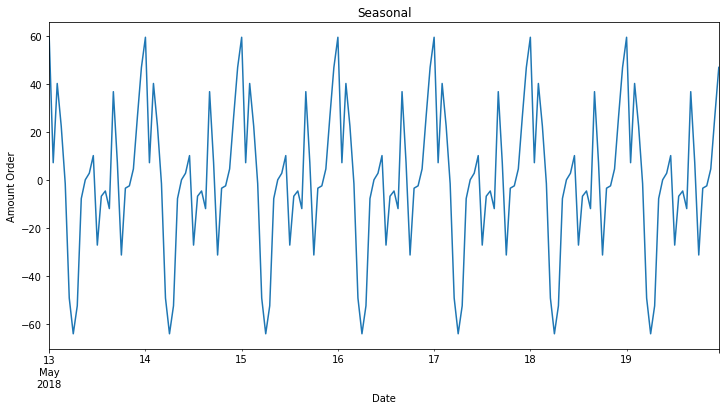

In [29]:
plt.figure(figsize=(12,6))
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Amount Order')

In [30]:
week_seasonal_stats = decomposed.seasonal.describe()
print("Seasonal Statistics from 13/05/2018 to 19/05/2018:\n", week_seasonal_stats)

Seasonal Statistics from 13/05/2018 to 19/05/2018:
 count    4.416000e+03
mean     3.089316e-16
std      2.615659e+01
min     -5.918267e+01
25%     -1.174773e+01
50%      3.261489e+00
75%      1.466896e+01
max      6.024811e+01
Name: seasonal, dtype: float64


#### Residual within Interval

Text(0, 0.5, 'Amount Order')

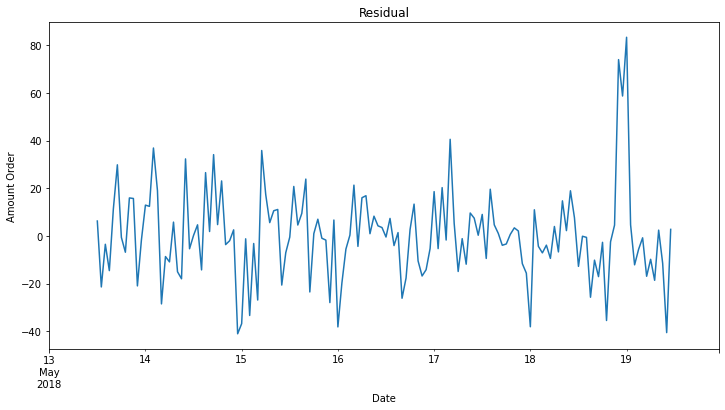

In [31]:
plt.figure(figsize=(12,6))
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Amount Order')

In [32]:
week_residual_stats = decomposed.seasonal.describe()
print("Residual Statistics from 13/05/2018 to 19/05/2018:\n", week_residual_stats)

Residual Statistics from 13/05/2018 to 19/05/2018:
 count    4.416000e+03
mean     3.089316e-16
std      2.615659e+01
min     -5.918267e+01
25%     -1.174773e+01
50%      3.261489e+00
75%      1.466896e+01
max      6.024811e+01
Name: seasonal, dtype: float64


#### Summary of Weekly Decomposed Analysis 

- Trend Component:
    - Average: ~79 orders/day
    - Variability: Low (Std: ~7.65)
    - Range: ~68 to ~94 orders/day
- Seasonal Component:
    - Average: Close to zero
    - Variability: Moderate (Std: ~26)
    - Range: ~-59 to ~60 orders/day
- Residual Component:
    - Average: Close to zero
    - Variability: Moderate (Std: ~26)
    - Range: ~-59 to ~60 orders/day

The analysis indicates that while there is a stable trend in daily taxi orders, there are also recurring patterns (seasonality) and unexplained variations (residuals) within the data.

#### Interval Weekly Analysis

In [33]:
data_week = data_hour['2018-05-13':'2018-05-19']

In [34]:
data_week['rolling_mean'] = data_week['num_orders'].rolling(10).mean()
data_week['rolling_std'] = data_week['num_orders'].rolling(10).std()

/tmp/ipykernel_198/1066165561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_week['rolling_mean'] = data_week['num_orders'].rolling(10).mean()
/tmp/ipykernel_198/1066165561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_week['rolling_std'] = data_week['num_orders'].rolling(10).std()


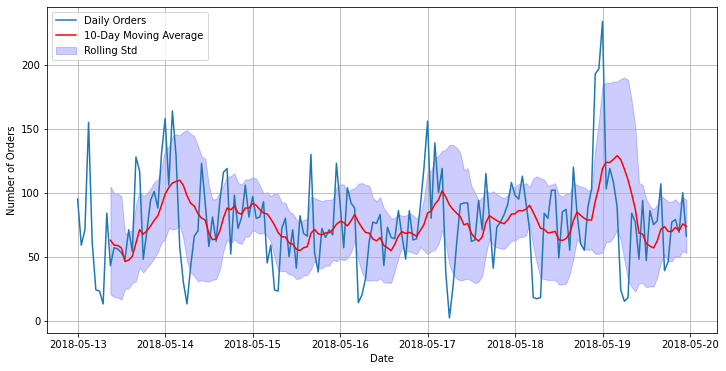

In [35]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(data_week.index, data_week['num_orders'], label='Daily Orders')
plt.plot(data_week.index, data_week['rolling_mean'], label='10-Day Moving Average', color='red')
plt.fill_between(data_week.index, data_week['rolling_mean'] - data_week['rolling_std'], 
                 data_week['rolling_mean'] + data_week['rolling_std'], color='blue', alpha=0.2, label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
data_week.describe()

,num_orders,rolling_mean,rolling_std
count,168.000000,159.000000,159.000000
mean,77.553571,77.752830,31.549888
std,36.002621,16.275554,12.821589
min,2.000000,46.200000,12.411912
25%,56.750000,67.650000,22.310211
50%,77.000000,75.300000,29.136461
75%,94.000000,85.750000,36.992724
max,234.000000,129.000000,78.382254


- Overall Trend and Variability:
    - The average number of daily taxi orders for the week is approximately 77.6, ranging from 2 to 234 orders.
    - Variability in daily orders is notable, with a standard deviation of around 36 orders.
    - The 10-day moving average provides a smoothed trend of daily orders, averaging slightly higher at approximately 77.8 orders.
- Trend Analysis:
    - The plotted data shows fluctuations in daily taxi orders throughout the week, with occasional spikes and dips.
    - The 10-day moving average helps in identifying the underlying trend by smoothing out short-term fluctuations.
- Variability Analysis:
    - The shaded area representing the rolling standard deviation indicates the variability around the moving average.
    - The standard deviation of the rolling mean is relatively lower compared to the standard deviation of the raw daily orders, suggesting a more stable trend when averaged over a 10-day period.

## Model Training

create function to make features and apply it to hourly data

In [37]:
def make_features(data, max_lag, rolling_size):
    # extract datetime components
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # create lagged features
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # create rolling mean feature
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

# apply the function on the data
make_features(data_hour, 24, 24)
data_hour.dropna(inplace=True)
data_hour.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2018,3,2,4,1,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2018,3,2,4,2,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2018,3,2,4,3,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2018,3,2,4,4,64.0,75.0,120.0,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


split the data into train and test

In [38]:
train, test = train_test_split(data_hour, test_size=0.1, shuffle=False, random_state=42)

split the data into features and target

In [39]:
feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [40]:
print("Feature Train", feature_train.shape)
print("Target Train",target_train.shape)
print("Feature Test", feature_test.shape)
print("Target Test",target_test.shape)

Feature Train (3952, 30)
Target Train (3952,)
Feature Test (440, 30)
Target Test (440,)


define models and hyperparameters to tune then train it

In [41]:
def train_models(feature_train, target_train):
    # define models and hyperparameters to tune
    models = {
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'LinearRegression': LinearRegression()
    }

    param_grid = {
        'RandomForestRegressor': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
        },
        'GradientBoostingRegressor': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7],
        },
        'LinearRegression': {
        }
    }

    # train models with different hyperparameters
    trained_models = {}
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(feature_train, target_train)
        best_model = grid_search.best_estimator_
        trained_models[model_name] = best_model
    
    return trained_models

In [42]:
trained_models = train_models(feature_train, target_train)

## Model Testing

In [43]:
def test_models(trained_models, feature_test, target_test):
    results = {}
    for model_name, model in trained_models.items():
        # evaluate model on test set
        predictions = model.predict(feature_test)
        rmse = np.sqrt(mean_squared_error(target_test, predictions))
        
        # evaluate model using cross-validation
        cross_val_scores = cross_val_score(model, feature_train, target_train, cv=5, scoring='neg_mean_squared_error')
        avg_rmse = np.sqrt(-cross_val_scores.mean())

        results[model_name] = {
            'RMSE': rmse,
            'Average RMSE (Cross-Validation)': avg_rmse
        }

    return results

In [44]:
results = test_models(trained_models, feature_test, target_test)

In [45]:
for model_name, result in results.items():
    print("Model:", model_name)
    print("RMSE:", result['RMSE'])
    print("Average RMSE (Cross-Validation):", result['Average RMSE (Cross-Validation)'])
    print()

Model: RandomForestRegressor
RMSE: 44.16819738227948
Average RMSE (Cross-Validation): 24.741196947307213

Model: GradientBoostingRegressor
RMSE: 42.82601618809463
Average RMSE (Cross-Validation): 24.055505464727876

Model: LinearRegression
RMSE: 45.83447405433358
Average RMSE (Cross-Validation): 26.080238949873586



### Summary Testing Phase

Based on the evaluation results, it can be observed that both the RandomForestRegressor and GradientBoostingRegressor models exhibit lower Root Mean Squared Error (RMSE) values on the test set compared to the LinearRegression model. Additionally, the average RMSE obtained from cross-validation for both ensemble models is notably lower than that of the LinearRegression model, indicating their robustness and effectiveness in capturing the underlying patterns in the data. Therefore, considering both the test set performance and cross-validation results, it is advisable to prioritize either the RandomForestRegressor or GradientBoostingRegressor for predicting the number of taxi orders, as they demonstrate superior predictive performance over the LinearRegression model.

## Conclusion

In this project, to improve the driver allocation during peak hours, the prediction of taxi orders are created and deployed by utilizing the historical data through several steps. The initial steps involve data preprocessing, analysis, and decomposition to identify trends, seasonality, and residuals. The analysis reveals a need for further processing, leading to resampling at daily intervals for clearer insights. Moving averages and rolling standard deviations are then employed to analyze weekly trends. Additionally, a feature engineering function is created to generate lagged features and rolling mean, followed by model training using RandomForestRegressor, GradientBoostingRegressor, and LinearRegression with varying hyperparameters. Finally, model performance is evaluated using RMSE on the test set and cross-validation, indicating that RandomForestRegressor and GradientBoostingRegressor outperform LinearRegression, suggesting them as preferred models for predicting taxi orders.

## Checklist

- [x]  Jupyter Notebook available to be opened and executed.
- [x]  No error in codes.
- [x]  Code cells are assigned neatly in right execution order.
- [x]  Data was downloaded and already prepared.
- [x]  Data was analyzed.
- [x]  Model is trained and hyperparameter is assigned and selected.
- [x]  Model evaluated and conclusion exist.
- [x] *RMSE* for *test set* not greater than 48.